# Introducción al Aprendizaje Automatizado

## Trabajo Práctico Nro 2

## Inés Cipullo

###2023

## Trabajo Previo

Definimos una función que entrena un red dada (ya definida) `epochs` cantidad de veces y mide los errores de la misma sobre los conjuntos de entrenamiento, validación y test en cada época. La función también toma el argumento `regression`, que deberá ser `True` cuando es un problema de regresión y `False` para clasificación, lo cual determinará cómo se mide el error: con `mean_squared_error` para regresión, y con `zero_one_loss` para clasificación.

Además, toma como argumnetos los datos de entrenamiento y sus respuestas, de validacion y sus respuestas, de test y sus respuestas, y devuelve, aparte de la red entrenada con el menor error de validación, los errores de train, validación y test medidos en cada época.

In [4]:
from copy import deepcopy
import sklearn as sk
from sklearn.base import is_classifier
import matplotlib.pyplot as plt


def error(y_true, y_pred, is_classif: bool):
  if is_classif:
    return sk.metrics.zero_one_loss(y_true=y_true, y_pred=y_pred)
  return sk.metrics.mean_squared_error(y_true=y_true, y_pred=y_pred)

def train_network(network, epochs, X_train, y_train, X_val, y_val, X_test, y_test):
  best_network = deepcopy(network)
  train_errors = []
  val_errors = []
  test_errors = []
  best_val_error = 1
  for i in range(epochs):
    network = network.fit(X_train, y_train)

    y_train_pred = network.predict(X_train)
    y_test_pred = network.predict(X_test)
    y_val_pred = network.predict(X_val)

    is_classif = is_classifier(network)
    train_error = error(y_train, y_train_pred, is_classif)
    test_error = error(y_test, y_test_pred, is_classif)
    val_error = error(y_val, y_val_pred, is_classif)

    train_errors.append(train_error)
    test_errors.append(test_error)
    val_errors.append(val_error)

    if val_error < best_val_error:
      best_network = deepcopy(network)
      best_val_error = val_error
    
  return best_network, train_errors, val_errors, test_errors


def plot_errors(train_errors, val_errors, test_errors, title):
  x_axis = range(len(train_errors))
  plt.plot(x_axis, train_errors, label="Train Error")
  plt.plot(x_axis, test_errors, label="Test Error")
  plt.plot(x_axis, val_errors, label="Validation Error")
  plt.xlabel("Epochs")
  plt.ylabel("Error")
  plt.title(title)
  plt.legend()
  plt.show()

## Ejercicio 1

A continuación, el código utilizado en el Trabajo Práctico Nro 0 para generar y graficár datos correspondientes al problema de las espirales anidadas.

Notar que el código fue levemente modificado (sin cambiar su funcionalidad) para adaptarlo al uso de los siguientes ejercicios.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


class Circular2DUniformDistribution:
	def __init__(self):
		self.dimension = 2
		self.radius = 1

	def generate_sample(self, sample_size: int):
		count = {"0": 0, "1": 0}
		cat_size = sample_size // 2
		x_values = []
		y_values = []
		categories = []

		while count["0"] < cat_size or count["1"] < cat_size:
			theta = np.random.uniform(0, 2*np.pi, 1).tolist()[0]
			radius = np.sqrt(np.random.uniform(0, self.radius, 1).tolist()[0])
			category = self._get_category(theta, radius)

			if count[f"{category}"] < cat_size:
				count[f"{category}"] += 1
				x_values.append(radius * np.cos(theta))
				y_values.append(radius * np.sin(theta))
				categories.append(category)

		return pd.DataFrame({"X": x_values, "Y": y_values, "Class": categories})

	def _get_category(self, theta, ro):
		r1 = self._curve_1(theta)
		r2 = self._curve_2(theta)
		if r1 < ro and ro < r2:
			return 0

		r1p = self._curve_1(theta + 2 * np.pi)
		r2p = self._curve_2(theta + 2 * np.pi)
		if r1p < ro and ro < r2p:
			return 0
	
		return 1

	def _curve_1(self, theta):
		return theta / (4 * np.pi)
	
	def _curve_2(self, theta):
		return (theta + np.pi) / (4 * np.pi)


def plot2(dataframe, title):
	colors = dataframe["Class"].map({0: 'b', 1: 'r'})
	dataframe.plot(x="X", y="Y", kind='scatter', c=colors)
	plt.title(title)
	plt.show()


def get_data_and_target(dataframe):
	"""Given a dataframe generated with Circular2DUniformDistribution, splits it into data and target."""
	# data = list(map(list, zip(dataframe["X"], dataframe["Y"])))
	data = dataframe[dataframe.columns[:-1]].values.tolist()
	target = dataframe["Class"].values.tolist()
	return data, target

Se entrenan redes neuronales para resolver el problema de clasificación de las espirales anidadas, con un número creciente de neuronas en la capa intermedia: 2, 10, 20, 40. Utilizamos un sample de 600 datos para ajustar los modelos (20% de ese conjunto separado al azar para conjunto de validación), y un sample de 2000 datos para testear. Se realizan 1000 evaluaciones del entrenamiento, cada una de 20 épocas para cada modelo. Para cada modelos obtenido se grafica en el plano `xy` las clasificaciones predichas sobre el conjunto de test.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier


def capacidad_de_modelado():
  espirales_anidadas = Circular2DUniformDistribution()
  fitting_data, fitting_target = get_data_and_target(espirales_anidadas.generate_sample(600))
  X_train, X_val, y_train, y_val = train_test_split(fitting_data, fitting_target, random_state=0, train_size=0.8)
  X_test, y_test = get_data_and_target(espirales_anidadas.generate_sample(2000))

  for N2 in [2,10,20,40]:
    clasif = MLPClassifier(
      hidden_layer_sizes=(N2,), 
      activation='logistic', 
      solver='sgd', 
      alpha=0.0, 
      batch_size=1, 
      learning_rate='constant', 
      learning_rate_init=0.1, 
      momentum=0.9, 
      nesterovs_momentum=False, 
      tol=0.0, 
      warm_start=True, 
      max_iter=20
    )
    
    best_network, train_errors, val_errors, test_errors = train_network(clasif, 1000, X_train, y_train, X_val, y_val, X_test, y_test)
    y_test_pred = best_network.predict(X_test)
    test_df_with_prediction = deepcopy(X_test)
    for i in range(len(y_test_pred)):
      test_df_with_prediction[i].append(y_test_pred[i])
    plot2(pd.DataFrame(test_df_with_prediction, columns=["X", "Y", "Class"]), f"Prediction from ANN trained with N2={N2}")


capacidad_de_modelado()


### Resultados 

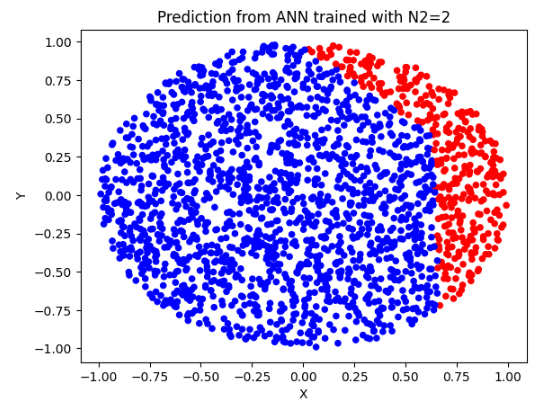

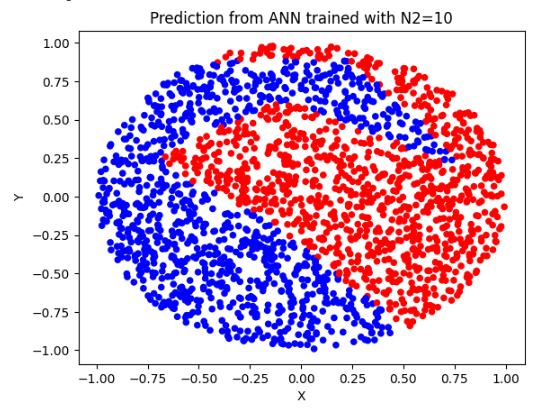

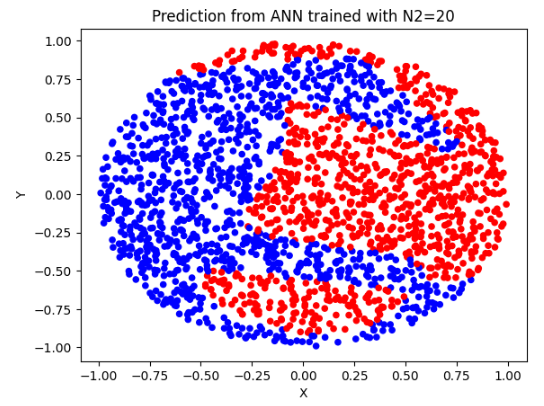

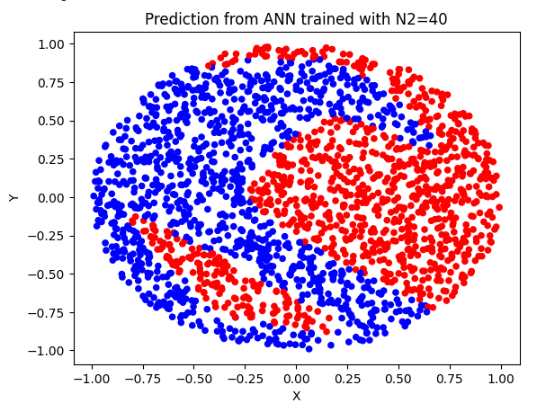

En los gráficos vemos que no se logra aproximar las espirales anidadas y que por lo tanto las predicciones no son precisas, obteniendo resultados bastante por debajo de los obtenidos con árboles de decisión. Esto nos lleva a pensar que este modelo con los parámetros utilizados no es adecuando para este problema en particular.

## Ejercicio 2

Se crean modelos de redes neurales con los parámetros `N2=6`, `epochs=50` y variando el valor de `learning_rate` entre `[0.1, 0.01, 0.001]` y el valor de `momentum` entre `[0, 0.5, 0.9]`. Para cada combinación de learning rate y momentum, se entrenan 20 redes con 300 evaluaciones para el dataset de *Dos Elipses*. Contamos con 2000 datos de test y se toman 500 datos de entrenamiento, 100 de los cuales se utilizan exclusivamente para validación. Se arma una tabla con los valores de `learning_rate` y `momentum`, el mínimo (de los mínimos) error de test y el promedio (de los mínimos) de los errores de test obtenidos por dicha red. Además, se grafican las curvas de error sobre los conjuntos de test, entrenamiento y validación para el red con menor promedio de errores de test.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier


def minimos_locales():
  dos_elipses_data_url = 'https://github.com/inescipullo/IAA/raw/main/TP2/Datasets/dos_elipses.data'
  dos_elipses_test_url = 'https://github.com/inescipullo/IAA/raw/main/TP2/Datasets/dos_elipses.test'

  columns = ['X','Y','Class']
  data_columns = columns[:-1]
  target_columns = columns[-1]

  dos_elipses_data_df = pd.read_csv(dos_elipses_data_url, header=None, names=columns, nrows=500)
  dos_elipses_test_df = pd.read_csv(dos_elipses_test_url, header=None, names=columns)
  X_test, y_test = dos_elipses_test_df[data_columns], dos_elipses_test_df[target_columns]
  X, y = dos_elipses_data_df[data_columns], dos_elipses_data_df[target_columns]
  X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0, train_size=400)

  table = []
  best_mean_test_error = 1
  best_test_error = 1
  best_momentum, best_learning_rate = -1, -1
  best_train_errors, best_val_errors, best_test_errors = [], [], []

  for momentum in [0, 0.5, 0.9]:
    for learning_rate in [0.1, 0.01, 0.001]:
      min_test_errors = []

      for i in range(10):
        clasif = MLPClassifier(
          hidden_layer_sizes=(6,), 
          activation='logistic', 
          solver='sgd', 
          alpha=0.0, 
          batch_size=1, 
          learning_rate='constant', 
          learning_rate_init=learning_rate, 
          momentum=momentum, 
          nesterovs_momentum=False, 
          tol=0.0, 
          warm_start=True, 
          max_iter=50
        )

        best_network, train_errors, val_errors, test_errors = train_network(clasif, 300, X_train, y_train, X_val, y_val, X_test, y_test)
        min_test_error = np.min(test_errors)
        min_test_errors.append(min_test_error)

        if best_test_error > min_test_error:
          best_test_error = min_test_error
          best_momentum = momentum
          best_learning_rate = learning_rate
          best_train_errors = np.copy(train_errors)
          best_val_errors = np.copy(val_errors)
          best_test_errors = np.copy(test_errors)

      table.append([learning_rate, momentum, np.min(min_test_errors), np.mean(min_test_error)])

  table = pd.DataFrame(table, columns=["Learning Rate", "Momentum", "Min Test Error", "Mean Test Error"])
  display(table)
  title = f"Prediction errors from ANN trained with momentum={best_momentum} and learning_rate={best_learning_rate}."
  plot_errors(best_train_errors, best_val_errors, best_test_errors, title)


minimos_locales()

### Resultados

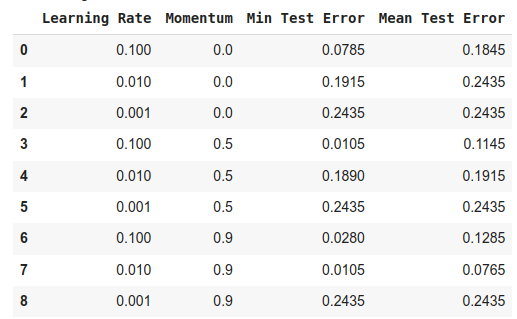

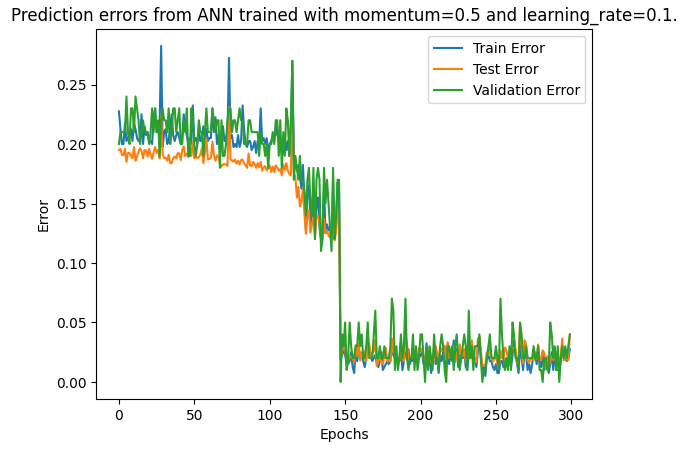

En la tabla observamos que se logran muy buenos resultados (errores de test bajos) con distintas combinaciones de valores de `learning_rate` y `momentum`, pero solo una de esas combinaciones, `eta=0.01` y `alfa=0.9`, mantiene un buen promedio de error de test mínimo a lo largo de las 10 ejecuciones, logrando un promedio de error de test mínimo de al rededor de un 7%.

Por su parte, la combinación de `eta=0.1` y `alfa=0.5` (graficada) es la que menor error de test logra, estando por debajo del 2%. En el gráfico también se pueden observar dos caídas abruptas, la primera de un 5% y la segunda de más o menos un 10% en las curvas de error, la primera al rededor de la época 120 de entrenamiento y la segunda cerca de la época 150. Esto se traduce en haber superado un mínimo local en dicha época. Con esto, podemos asumir que esta función de error tiene mínimos locales cerca del 0.2 y del 0.15, y volviendo a mirar la tabla, notamos que varias combinacions de valores de learning rate y momentum no funcionan correctamente para este problema justamente porque no logran superar algún mínimo local y quedan estancadas ahí.

## Ejercicio 3

Se crean y entrenan modelos de redes neuronales para el dataset *Ikeda* con un conjunto de 100 datos, variando el porcentaje de datos usados para entrenamiento y validación. Para cada red, se miden los errores sobre conjuntos de entrenamiento, validación y test (conjunto de 4800 datos), para luego graficarlos.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor


def regularizacion1():
  ikeda_data_url = 'https://github.com/inescipullo/IAA/raw/main/TP2/Datasets/ikeda.data'
  ikeda_test_url = 'https://github.com/inescipullo/IAA/raw/main/TP2/Datasets/ikeda.test'

  columns = ['Col1','Col2','Col3','Col4','Col5','Col6']
  data_columns = columns[:-1]
  target_columns = columns[-1]

  ikeda_data_df = pd.read_csv(ikeda_data_url, header=None, names=columns, delim_whitespace=True)
  ikeda_test_df = pd.read_csv(ikeda_test_url, header=None, names=columns, delim_whitespace=True)
  X_test, y_test = ikeda_test_df[data_columns], ikeda_test_df[target_columns]

  for train_size in [0.95, 0.75, 0.5]:
    X, y = ikeda_data_df[data_columns], ikeda_data_df[target_columns]
    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0, train_size=train_size)

    regr = MLPRegressor(
      hidden_layer_sizes=(30,), 
      activation='logistic', 
      solver='sgd', 
      alpha=0.0, 
      batch_size=1, 
      learning_rate='constant', 
      learning_rate_init=0.01,
      momentum=0.9,
      nesterovs_momentum=False,
      tol=0.0,
      warm_start=True,
      max_iter=50
    )
    
    best_network, train_errors, val_errors, test_errors = train_network(regr, 400, X_train, y_train, X_val, y_val, X_test, y_test)
    title = f"Prediction errors from ANN trained with {int(train_size * 100)}% for training and {int((1-train_size) * 100)}% for validation"
    plot_errors(train_errors, val_errors, test_errors, title)


regularizacion1()


### Resultados

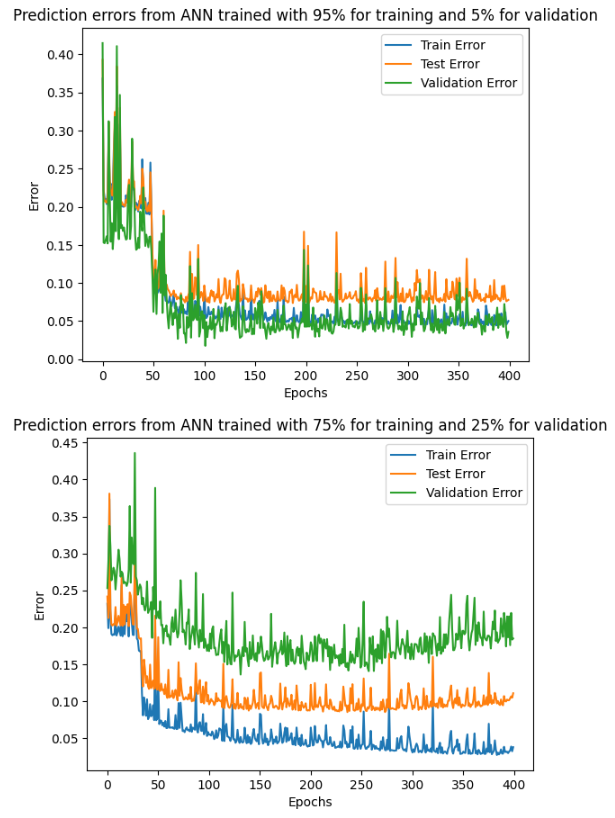

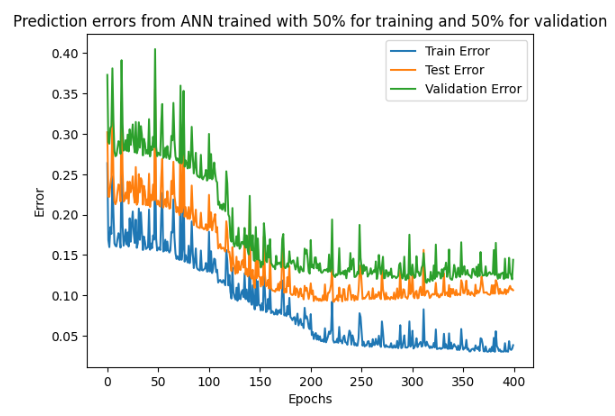

Lo primero que se observa es que el error de validación tiende a ser mayor que el error de test y el de entrenamiento, excepto en el primer caso, donde el error de validación es incluso menor al error de entrenamiento. Esto me lleva a pensar que un conjunto de validación del 5% no es lo suficientemente significativo como para incluir casos menos triviales de predecir.

Además, podemos observar que cuanto más pareja la división de datos entre conjuntos de entrenamiento y de validación, más suave es la caída en las curvas de error. También notamos que el error de test tiende al mismo valor en las últimas evaluaciones, independientemente de como se dividieron los conjuntos de entrenamiento y validación.

## Ejercicio 4

En este ejercicio se evalúa otro tipo de regularización que no utiliza un conjunto de validación, por eso redefinimos la función `train_network` para que en lugar del error sobre el conjunto de validación, devuelva la suma de los valores al cuadrado de todos los pesos de la red en la época correspondiente.

In [ ]:
import sklearn as sk


def train_network_2(network, epochs, X_train, y_train, X_test, y_test):
  train_errors = []
  squared_weights_sums = []
  test_errors = []
  for i in range(epochs):
    network = network.fit(X_train, y_train)

    y_train_pred = network.predict(X_train)
    y_test_pred = network.predict(X_test)
    weights = network.coefs_

    train_error = sk.metrics.mean_squared_error(y_true=y_train, y_pred=y_train_pred)
    test_error = sk.metrics.mean_squared_error(y_true=y_test, y_pred=y_test_pred)
    squared_weights_sum = sum(map(lambda a : np.sum(np.power(a, 2)), weights))  # doble suma porque es una matriz

    train_errors.append(train_error)
    test_errors.append(test_error)
    squared_weights_sums.append(squared_weights_sum)
    
  return train_errors, test_errors, squared_weights_sums

Se crean modelos de redes neurales con los parámetros `N2=6`, `learning_rate=0.1`, `momentum=0.3`, `epochs=20` y variando el valor de `gamma` (weight-decay) desde `10^-6` hasta `10^0` de a un orden cada vez. Estas redes se entrena con 4000 evaluaciones para el dataset *Sunspots*. Contamos con 107 datos de test y 180 datos de entrenamiento. Se arma una tabla con el valor de `gamma`, los errores de test y entrenamieto obtenidos por dicha red y la suma de los pesos de la red al cuadrado. Además, se grafican las curvas de error sobre los conjuntos de test y entrenamiento para el red con menor error de entrenamiento y para la red con menor error de test.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt


def plot_errors2(train_errors, test_errors, title):
  x_axis = range(len(train_errors))
  plt.plot(x_axis, train_errors, label="Train Error")
  plt.plot(x_axis, test_errors, label="Test Error")
  plt.xlabel("Epochs")
  plt.ylabel("Error")
  plt.title(title)
  plt.legend()
  plt.show()


def plot_weights(weights, title):
  x_axis = range(len(weights))
  plt.plot(x_axis, weights, label="Suma de los pesos al cuadrado")
  plt.xlabel("Epochs")
  plt.ylabel("Weights")
  plt.title(title)
  plt.legend()
  plt.show()


def regularizacion2():
  ssp_data_url = 'https://github.com/inescipullo/IAA/raw/main/TP2/Datasets/ssp.data'
  ssp_test_url = 'https://github.com/inescipullo/IAA/raw/main/TP2/Datasets/ssp.test'

  columns = [f'Col{i}' for i in range(13)]
  data_columns = columns[:-1]
  target_columns = columns[-1]

  ssp_data_df = pd.read_csv(ssp_data_url, header=None, names=columns)
  ssp_test_df = pd.read_csv(ssp_test_url, header=None, names=columns)
  X_train, y_train = ssp_data_df[data_columns], ssp_data_df[target_columns]
  X_test, y_test = ssp_test_df[data_columns], ssp_test_df[target_columns]

  table = []
  best_min_test_error, best_min_train_error = 1, 1
  min_test_gamma, min_train_gamma = -1, -1
  min_test_train_errors, min_test_test_errors, min_test_squared_weights_sums = [], [], []
  min_train_train_errors, min_train_test_errors, min_train_squared_weights_sums = [], [], []
  gammas = [10 ** i for i in range(-6,1)]
  for gamma in gammas:
    regr = MLPRegressor(
        hidden_layer_sizes=(6,), 
        activation='logistic', 
        solver='sgd', 
        alpha=gamma, 
        batch_size=1, 
        learning_rate='constant', 
        learning_rate_init=0.05,
        momentum=0.3,
        nesterovs_momentum=False,
        tol=0.0,
        warm_start=True,
        max_iter=20
    )

    train_errors, test_errors, squared_weights_sums = train_network_2(regr, 4000, X_train, y_train, X_test, y_test)
    min_test_error = np.min(test_errors)
    min_test_error_index = test_errors.index(min_test_error)
    min_train_error = train_errors[min_test_error_index]
    table.append([gamma, min_test_error, min_train_error, squared_weights_sums[min_test_error_index]])

    if best_min_test_error > min_test_error:
      best_min_test_error = min_test_error
      min_test_gamma = gamma
      min_test_train_errors = np.copy(test_errors)
      min_test_test_errors = np.copy(train_errors)
      min_test_squared_weights_sums = np.copy(squared_weights_sums)

    if best_min_train_error > min_train_error:
      best_min_train_error = min_test_error
      min_train_gamma = gamma
      min_train_train_errors = np.copy(test_errors)
      min_train_test_errors = np.copy(train_errors)
      min_train_squared_weights_sums = np.copy(squared_weights_sums)

  table = pd.DataFrame(table, columns=["Gamma", "Test Error", "Train Error", "Weight Decay"])
  display(table)
  title_test = f"Prediction errors from ANN trained with {min_test_gamma} "
  plot_errors2(min_test_train_errors, min_test_test_errors, title_test)
  plot_weights(min_test_squared_weights_sums, title_test)
  title_train = f"Prediction errors from ANN trained with {min_train_gamma} "
  plot_errors2(min_train_train_errors, min_train_test_errors, title_train)
  plot_weights(min_train_squared_weights_sums, title_train)


regularizacion2()

### Resultados

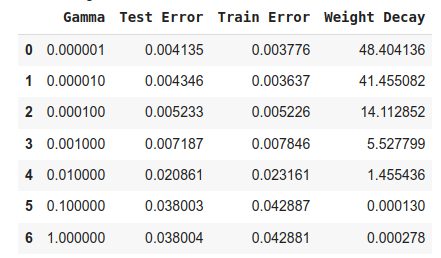

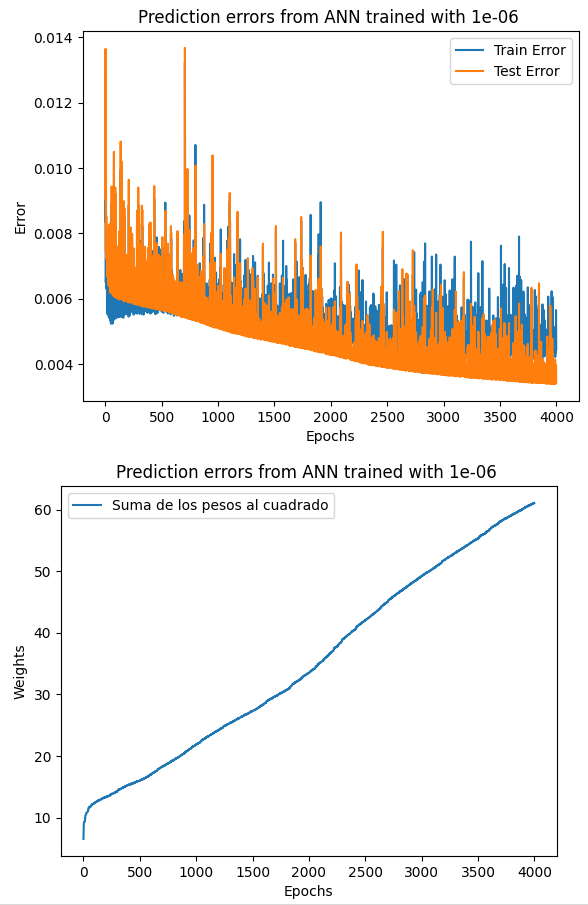

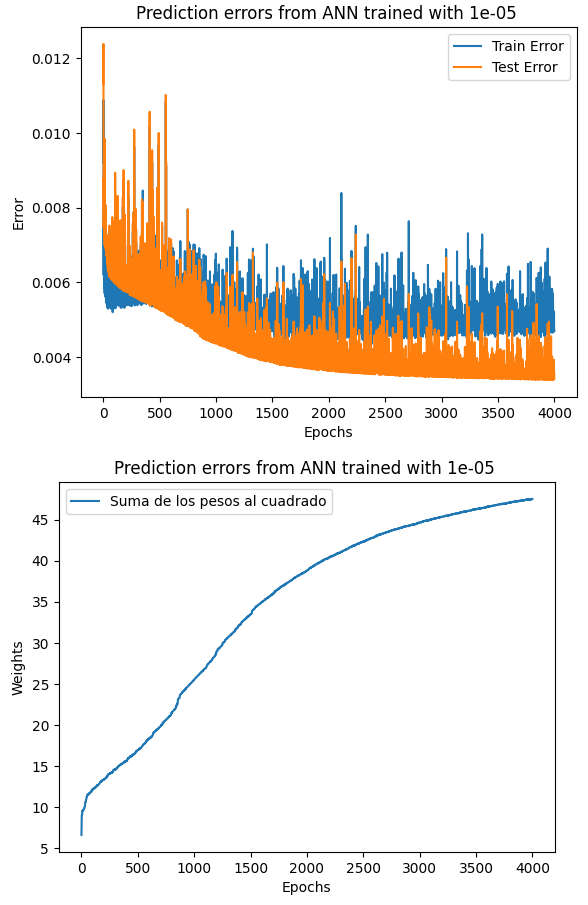



En la tabla podemos observar que a mayor valor de `gamma`, mayor es el error de test, tendencia que se mantiene con el error de entrenamiento excepto para los 2 valores de `gamma` mas pequeños, y claramente la suma de los pesos de las redes al cuadrado es menor a mayor valor de `gamma` ya que aumenta la penalización.

En cuanto a los gráficos, podemos observar como el error de entrenamiento mejora muy poco según pasan las épocas, pero en el error de test se notan mejoras más significativas. Esto denota como funciona la regularización por penalización, que ayuda a la red a generalizar mejor sobre los datos y así evitar el sobreajuste, según pasan las épocas. 

La idea de graficar los errores para la red con menor error de test y la red con menor error de entrenamiento era para mostrar el valor de `gamma` que se podría decir mejor funciona para este problema, y un valor de `gamma` para el cual la red termina sobreajustando y no es efectiva. Pero resulta que ambos gráficos son similares, siendo los mínimos errores de test y entrenamiento distintos por solo unas milésimas.

Siguiendo los valores expuestos en la tabla, diría que no hubo sobreajuste de ninguna red.

## Ejercicio 5

Se generar datasets de datos diagonales y paralelos con C = 0.78, n = 250 para el conjunto de entrenamiento y n = 10000 para el de test, variando esta vez el valor de d según la siguiente lista: 2, 4, 8, 16, 32. Para cada valor de `d`, se crean 20 conjuntos distintos de entrenamiento, y uno solo de test.

Se entrenan árboles de decisión y redes neuronales para resolver dicho problema, y se grafican de los errores de test y entrenamiento.

Para las redes neuronales se utilizan los siguientes parámetros: `N2=8`, `eta=0.1`, `alfa=0.3`, `epochs=20` y se entrena con 200 evaluaciones.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


class MultidimensionalGaussianDistribution:
	def generate_sample_a(self, n: int, dimension: int, C: float):
		center_0 = np.ones(dimension) * -1
		center_1 = np.ones(dimension)
		variance = (C * np.sqrt(dimension))**2

		sample_0 = self._sample_with_center_and_variance(n, dimension, center_0, variance, 0)
		sample_1 = self._sample_with_center_and_variance(n, dimension, center_1, variance, 1)
		columns = [f"Dim{i+1}" for i in range(dimension)]
		columns.append("Class")
		dataframe = pd.DataFrame(sample_0+sample_1, columns=columns)
		return dataframe

	def generate_sample_b(self, n: int, dimension: int, C: float):
		center_0 = np.append(np.ones(1), np.zeros(dimension-1))
		center_1 = np.append(np.ones(1)*-1, np.zeros(dimension-1))
		variance = C**2

		sample_0 = self._sample_with_center_and_variance(n, dimension, center_0, variance, 0)
		sample_1 = self._sample_with_center_and_variance(n, dimension, center_1, variance, 1)
		columns = [f"Dim{i+1}" for i in range(dimension)]
		columns.append("Class")
		dataframe = pd.DataFrame(sample_0+sample_1, columns=columns)
		return dataframe


	def _sample_with_center_and_variance(self, n: int, dimension: int, center, variance, category):
		covariance_matrix = np.identity(dimension) * (variance**2)
		sample = np.random.multivariate_normal(mean=center, cov=covariance_matrix, size=n//2)
		sample_with_class = [point + [category] for point in sample.tolist()]
		return sample_with_class

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB


class DimensionalidadTree:
  def __init__(self):
    self.df_generator = MultidimensionalGaussianDistribution()
    self.test_sample_size = 10000
    self.test_errors = {}
    self.train_errors = {}

  def varying_dimension(self, sample_size: int, dimensions: list[int], C: float):
    """Ejercicio 4 - Dimensionalidad."""
    for d in dimensions:
      self.test_errors[f"{d}"] = {"a": [], "b": []}
      self.train_errors[f"{d}"] = {"a": [], "b": []}

      test_df_a = self.df_generator.generate_sample_a(n=self.test_sample_size, dimension=d, C=C)
      test_df_b = self.df_generator.generate_sample_b(n=self.test_sample_size, dimension=d, C=C)

      for i in range(20):
        df_a = self.df_generator.generate_sample_a(n=sample_size, dimension=d, C=C)
        df_b = self.df_generator.generate_sample_b(n=sample_size, dimension=d, C=C)
        self._train_and_test_tree_for_df(df_a, test_df_a, d, "a")
        self._train_and_test_tree_for_df(df_b, test_df_b, d, "b")

    self._plot_errors()

  def _train_and_test_tree_for_df(self, df, test_df, var, sample: str):
    data, target = self._get_data_and_target(df)
    test_data, test_target = self._get_data_and_target(test_df)

    trained_decision_tree = self._train_decision_tree(data, target)
    test_df_with_prediction = self._test_decision_tree(trained_decision_tree, test_df)
    train_df_with_prediction = self._test_decision_tree(trained_decision_tree, df)

    self.test_errors[f"{var}"][sample].append(1 - accuracy_score(test_target, test_df_with_prediction["Class"]))
    self.train_errors[f"{var}"][sample].append(1 - accuracy_score(target, train_df_with_prediction["Class"]))

  def _get_data_and_target(self, dataframe):
    data = dataframe[dataframe.columns[:-1]]
    target = dataframe["Class"].values.tolist()
    return data, target

  def _train_decision_tree(self, data, target):
    decision_tree = DecisionTreeClassifier(criterion="entropy", min_impurity_decrease=0.005, random_state=0, min_samples_leaf=5)
    return decision_tree.fit(data, target)
  
  def _test_decision_tree(self, decision_tree, test_df):
    test_data, _ = self._get_data_and_target(test_df)
    prediction = decision_tree.predict(test_data)
    test_data["Class"]=prediction
    return pd.DataFrame(test_data)

  def _plot_errors(self):
    x = []
    y_a_test = []
    y_b_test = []
    y_a_train = []
    y_b_train = []
    for n in self.test_errors.keys():
      x.append(int(n))
      y_a_test.append(np.mean(self.test_errors[n]["a"]))
      y_b_test.append(np.mean(self.test_errors[n]["b"]))
      y_a_train.append(np.mean(self.train_errors[n]["a"]))
      y_b_train.append(np.mean(self.train_errors[n]["b"]))

    plt.plot(x, y_a_test, linestyle='dashed', marker='s', label="Tree - Test error - Sample A")
    plt.plot(x, y_b_test, linestyle='dashed', marker='s', label="Tree - Test error - Sample B")
    plt.plot(x, y_a_train, linestyle='dashed', marker='s', label="Tree - Train error - Sample A")
    plt.plot(x, y_b_train, linestyle='dashed', marker='s', label="Tree - Train error - Sample B")

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from copy import deepcopy


def plot_dimensionalidad_network(errors):
  x = [2,4,8,16,32]
  y_test_a = []
  y_test_b = []
  y_train_a = []
  y_train_b = []
  for d in errors.keys():
    y_test_a.append(np.mean(errors[f"{d}"]["a_test"]))
    y_test_b.append(np.mean(errors[f"{d}"]["b_test"]))
    y_train_a.append(np.mean(errors[f"{d}"]["a_train"]))
    y_train_b.append(np.mean(errors[f"{d}"]["b_train"]))
  
  plt.plot(x, y_test_a, marker='s', label="Network - Test error - Sample A")
  plt.plot(x, y_test_b, marker='s', label="Network - Test error - Sample B")
  plt.plot(x, y_train_a, marker='s', label="Network - Train error - Sample A")
  plt.plot(x, y_train_b, marker='s', label="Network - Train error - Sample B")
  
  plt.xlabel("Dimension")
  plt.ylabel("Error")
  plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
  plt.title("Dimensionalidad")
  plt.show()

def dimensionalidad_network():
  C = 0.78
  n = 250
  n_test = 10000
  dimensions = [2,4,8,16,32]
  df_generator = MultidimensionalGaussianDistribution()
  errors = {}
  for d in dimensions:
    errors[f"{d}"] = {"a_test": [], "b_test": [], "a_train": [], "b_train": []}
    data_columns = [f'Dim{i+1}' for i in range(d)]
    target_columns = "Class"

    test_df_a = df_generator.generate_sample_a(n=n_test, dimension=d, C=C)
    X_test_a, y_test_a = test_df_a[data_columns], test_df_a[target_columns]
    test_df_b = df_generator.generate_sample_b(n=n_test, dimension=d, C=C)
    X_test_b, y_test_b = test_df_b[data_columns], test_df_b[target_columns]

    for i in range(20):
      df_a = df_generator.generate_sample_a(n=n, dimension=d, C=C)
      X_a, y_a = df_a[data_columns], df_a[target_columns]
      df_b = df_generator.generate_sample_b(n=n, dimension=d, C=C)
      X_b, y_b = df_b[data_columns], df_b[target_columns]

      X_train_a, X_val_a, y_train_a, y_val_a = train_test_split(X_a, y_a, random_state=0, train_size=0.8)
      X_train_b, X_val_b, y_train_b, y_val_b = train_test_split(X_b, y_b, random_state=0, train_size=0.8)

      clasif_a = MLPClassifier(
        hidden_layer_sizes=(6,), 
        activation='logistic', 
        solver='sgd', 
        alpha=0.0, 
        batch_size=1, 
        learning_rate='constant', 
        learning_rate_init=0.1, 
        momentum=0.3, 
        nesterovs_momentum=False, 
        tol=0.0, 
        warm_start=True, 
        max_iter=20
      )
      clasif_b = deepcopy(clasif_a)

      best_network_a, _, _, _ = train_network(clasif_a, 200, X_train_a, y_train_a, X_val_a, y_val_a, X_test_a, y_test_a)
      best_network_b, _, _, _ = train_network(clasif_b, 200, X_train_b, y_train_b, X_val_b, y_val_b, X_test_b, y_test_b)

      y_test_a_pred = best_network_a.predict(X_test_a)
      y_test_b_pred = best_network_b.predict(X_test_b)
      y_train_a_pred = best_network_a.predict(X_train_a)
      y_train_b_pred = best_network_b.predict(X_train_b)

      test_error_a = error(y_test_a, y_test_a_pred, True)
      test_error_b = error(y_test_b, y_test_b_pred, True)
      train_error_a = error(y_train_a, y_train_a_pred, True)
      train_error_b = error(y_train_b, y_train_b_pred, True)
      errors[f"{d}"]["a_test"].append(test_error_a)
      errors[f"{d}"]["b_test"].append(test_error_b)
      errors[f"{d}"]["a_train"].append(train_error_a)
      errors[f"{d}"]["b_train"].append(train_error_b)

  plot_dimensionalidad_network(errors)


def dimensionalidad():
  DimensionalidadTree().varying_dimension(sample_size=250, dimensions=[2,4,8,16,32], C=0.78)
  dimensionalidad_network()


dimensionalidad()

### Resultados

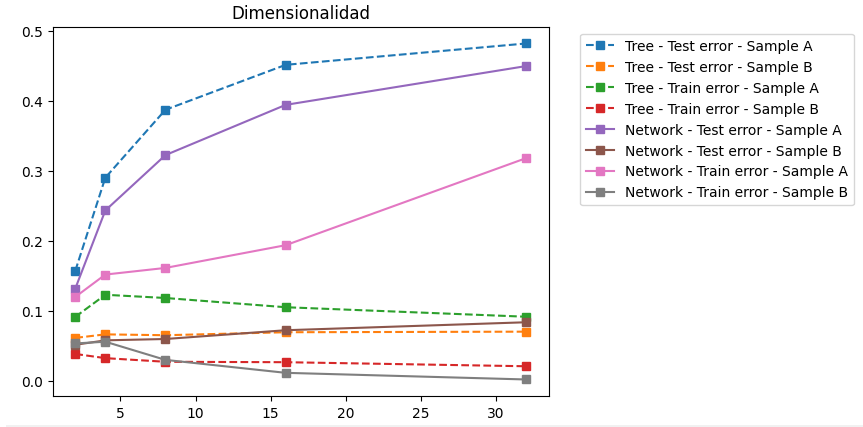

Observamos como para el sample B (datos paralelos) las redes neuronales son mejores en las dimensiones bajas y los árboles de decisión son mejor en las dimensiones altas. Creemos que esto ocurre porque las redes en dimensiones altas parecen sobreajustarse, ya que se alcanza un error de entrenamiento nulo y justamnete empeora el error de test. 

Para el sample A (datos diagonales), sabiamos que la dimensionalidad afectaba mucho más ya que se vacía es espacio y la solución ideal es difícil de predecir. Sin embargo, vemos como las redes mejoras a los árboles en el test de error, pero no es asi el caso para el de entrenamiento.

Podría concluir que los árboles de decisión son mejores para problemas lineales como el paralelo, independientemente de la dimensión, mientras que las redes se desempañan un poco mejor que los árboles en los problema no lineales como el diagonal.

## Ejercicio 6.1

Se crea un modelo de red neural con los parámetros `N2=8`, `eta=0.1`, `alfa=0.3`, `epochs=40` y se entrena con 500 evaluaciones para el dataset *Iris*. Del dataset se toma un tercio de los datos para test, y de los dos tercios restantes, se utiliza un 20% para validación y el resto para entrenamiento. Se grafican las curvas de error sobre los conjuntos de test, entrenamiento y validación.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.neural_network import MLPClassifier


def multiclase1():
  iris = load_iris()
  X = iris.data
  y = iris.target
  X_fitting, X_test, y_fitting, y_test = train_test_split(X, y, random_state=0, test_size=1/3)
  X_train, X_val, y_train, y_val = train_test_split(X_fitting, y_fitting, random_state=0, test_size=0.2)

  clasif = MLPClassifier(
    hidden_layer_sizes=(8,), 
    activation='logistic', 
    solver='sgd', 
    alpha=0.0, 
    batch_size=1, 
    learning_rate='constant', 
    learning_rate_init=0.1, 
    momentum=0.3, 
    nesterovs_momentum=False, 
    tol=0.0, 
    warm_start=True, 
    max_iter=40
  )

  best_network, train_errors, val_errors, test_errors = train_network(clasif, 500, X_train, y_train, X_val, y_val, X_test, y_test)
  title = "Prediction errors from ANN for Iris dataset"
  plot_errors(train_errors, val_errors, test_errors, title)


multiclase1()

### Resultados

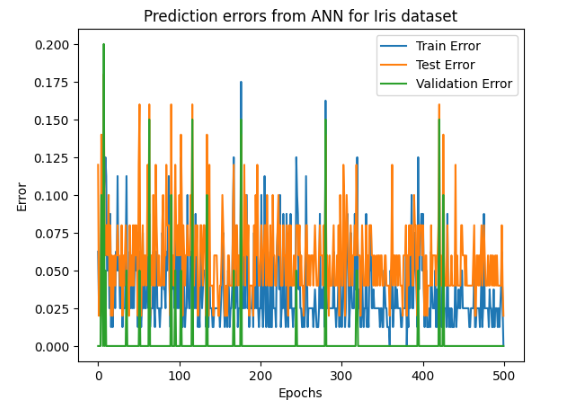

Vemos como el error de validación es nulo desde el principio salvo por algunos picos y como en varias oportunidades a lo largo de las evaluaciones se alcanzan los mínimos del error de entrenamiento y de test, que son 0 y aproximadamente 0.02 respectivamente. Esto ocurre en varias oportunidades dentro de las 500 evaluaciones, con lo cual más allá de las grandes variaciones que puede haber, el modelo resulta muy bueno para predecir este problema, incluso con pocas evaluaciones.

Se probó también entrenar la red con 1000, 2000 y 3000 evaluaciones, pero no arrojaron datos mucho más significativos. Con esto me refiero a que pasando las 500 evaluaciones se mantienen las variaciones de las curvas al rededor del 0.05 como se puede observar en la gráfica y el error de test no se mejora. Esto me lleva a pensar en la posibilidad de que los datos de test tengan un mínimo error posible distinto de cero. Por último, algo que si resulto interesante como para mencionar, es que casi sobre la evaluación número 3000 (un poco antes), las curvas de error se vuelven constantes, siendo el error de entrenamiento y validación nulo y el error de test aproximadamente 0.02. Esto significa que la red neuronal se vuelve estable y sus pesos dejan de variar, por lo que sería completemente obsoleto continuar entrenando la red pasado ese punto.

## Ejercicio 6.2

Se crea un modelo de red neural con los parámetros N2=16, eta=0.1, alfa=0.3, epochs=100 y se entrena con 2000 evaluaciones para el dataset *Faces*. Contamos con 364 datos de test y 260 datos de entrenamiento, de los cuales un 20% se utilizaran exclusivamente para validación. Previo a utilizar los datos, hubo que re-escalarlos al rango `[0,1]` (normalizarlos). Se grafican las curvas de error sobre los conjuntos de test, entrenamiento y validación.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
import numpy as np
import pandas as pd


def multiclase2():
  faces_data_url = 'https://github.com/inescipullo/IAA/raw/main/TP2/Datasets/faces.data'
  faces_test_url = 'https://github.com/inescipullo/IAA/raw/main/TP2/Datasets/faces.test'

  columns = [f'Col{i}' for i in range(961)]
  data_columns = columns[:-1]
  target_columns = columns[-1]

  faces_data_df = pd.read_csv(faces_data_url, header=None, names=columns)
  faces_test_df = pd.read_csv(faces_test_url, header=None, names=columns)
  X_test, y_test = faces_test_df[data_columns], faces_test_df[target_columns]
  X, y = faces_data_df[data_columns], faces_data_df[target_columns]

  # Normalizamos los datos
  max_value = max(faces_data_df.max().max(), faces_test_df.max().max())
  min_value = min(faces_data_df.min().min(), faces_test_df.min().min())
  X_test = (X_test - min_value) / (max_value - min_value)
  X = (X - min_value) / (max_value - min_value)

  X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0, train_size=0.8)

  clasif = MLPClassifier(
    hidden_layer_sizes=(16,), 
    activation='logistic', 
    solver='sgd', 
    alpha=0.0, 
    batch_size=1, 
    learning_rate='constant', 
    learning_rate_init=0.1, 
    momentum=0.3, 
    nesterovs_momentum=False, 
    tol=0.0, 
    warm_start=True, 
    max_iter=20
  )
    
  best_network, train_errors, val_errors, test_errors = train_network(clasif, 400, X_train, y_train, X_val, y_val, X_test, y_test)
  title = f"Prediction errors from ANN for Faces dataset."
  plot_errors(train_errors, val_errors, test_errors, title)


multiclase2()

### Resultados

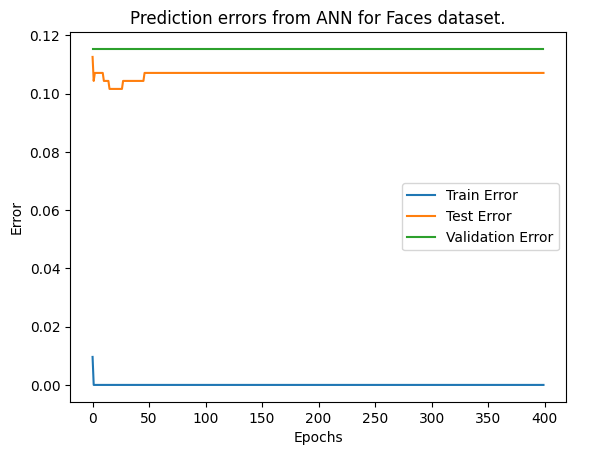

A diferencia de todo el resto de problemas, en este caso se observa muy poca variación en las curvas de error luego de aproximadamente la época 50. Esto me lleva a pensar que la red es capaz de ajustar sus pesos en una pocas iteraciones de entrenamiento y luego no percibe más cambios. Notamos que el error de entrenamiento es nulo, excepto en la primer época, y el error de validación no ve cambios en ningún momento, mantiendose constante apenas por debajo de 0.12. El error de test percibe una mejoría durante las primeras épocas y luego una pequeña suba, antes de estabilizarse por debajo del error de validación. Consluiría que este problema es mejor entrenarlo solo unas pocas épocas, ya que parece que arrojaría mejores resultados

## Ejercicio 7

Se crean y entrenan modelos de redes neuronales utilizando minibatchs para el dataset *Sunspots*, haciendo uso del parámetro `batch_size`, y comparandolo con los resultados de una red sin minibatch (`batch_size=1`). Para cada red, se miden los errores sobre conjuntos de entrenamiento, validación y test, para luego graficarlos.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
import pandas as pd


def mini_batch():
  ssp_data_url = 'https://github.com/inescipullo/IAA/raw/main/TP2/Datasets/ssp.data'
  ssp_test_url = 'https://github.com/inescipullo/IAA/raw/main/TP2/Datasets/ssp.test'

  columns = [f'Col{i}' for i in range(13)]
  data_columns = columns[:-1]
  target_columns = columns[-1]

  ssp_data_df = pd.read_csv(ssp_data_url, header=None, names=columns)
  ssp_test_df = pd.read_csv(ssp_test_url, header=None, names=columns)
  X_test, y_test = ssp_test_df[data_columns], ssp_test_df[target_columns]
  X, y = ssp_data_df[data_columns], ssp_data_df[target_columns]

  for batch_size in [1, 10, 20]:
    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0, train_size=0.8)

    regr = MLPRegressor(
      hidden_layer_sizes=(6,), 
      activation='logistic', 
      solver='sgd', 
      alpha=0.0, 
      batch_size=1, 
      learning_rate='constant', 
      learning_rate_init=0.05,
      momentum=0.3,
      nesterovs_momentum=False,
      tol=0.0,
      warm_start=True,
      max_iter=200
    )
    
    best_network, train_errors, val_errors, test_errors = train_network(regr, 2000, X_train, y_train, X_val, y_val, X_test, y_test)
    title = f"Prediction errors from ANN with batch_size={batch_size}"
    plot_errors(train_errors, val_errors, test_errors, title)


mini_batch()

### Resultados

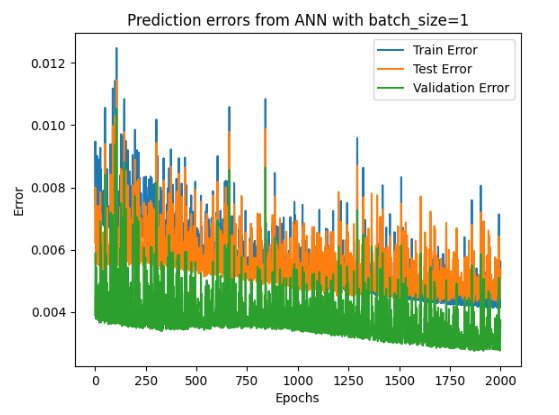

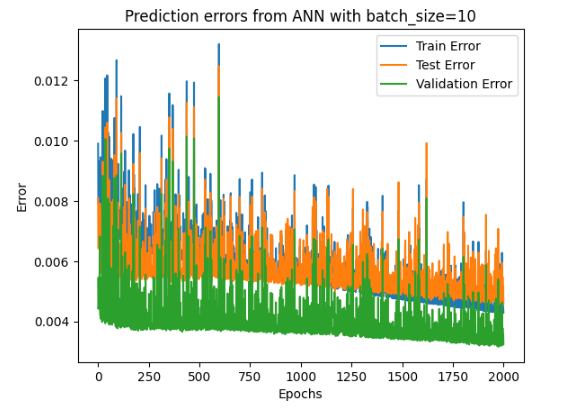

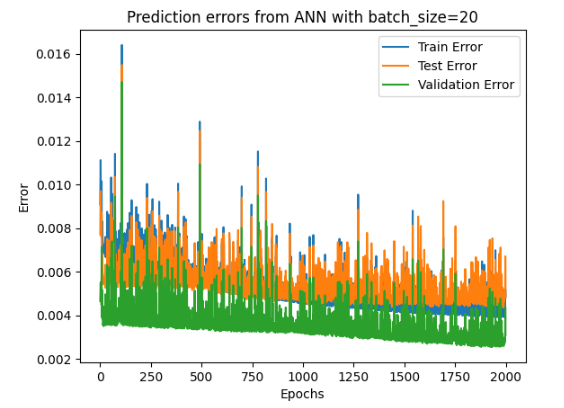

Notamos que a mayor `batch_size`, menores variaciones en las curvas de error. También se observa que si bien el menor error de test alcanzado es aproximadamente el mismo en todos los gráficos, el menor error de validación parece ser mayor conforme aumneta el `batch_size`, aunque las diferencias son muy mínimas y capaz no es significativo.